In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [0]:
planet = untar_data(URLs.PLANET_SAMPLE); path

PosixPath('/root/.fastai/data/planet_sample')

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/planet_sample/labels.csv'),
 PosixPath('/root/.fastai/data/planet_sample/train')]

In [0]:
path_anno = path/'valid'
path_img = path/'jpg'

In [0]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-102-flowers/jpg/image_02029.jpg'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/jpg/image_03388.jpg'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/jpg/image_08108.jpg'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/jpg/image_01656.jpg'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/jpg/image_03235.jpg')]

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [0]:
df = pd.read_csv(planet/'labels.csv')
df.head()

data = ImageDataBunch.from_csv(planet, folder='train', size=128, suffix='.jpg', label_delim=' ',
    ds_tfms=get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.))

#data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=224, bs=bs, test = 'test')
#data.normalize(imagenet_stats)

#print(data.classes)

#data.show_batch(rows=3, figsize=(10,20))
#ImageDataBunch

#data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
 #                                 ).normalize(imagenet_stats)

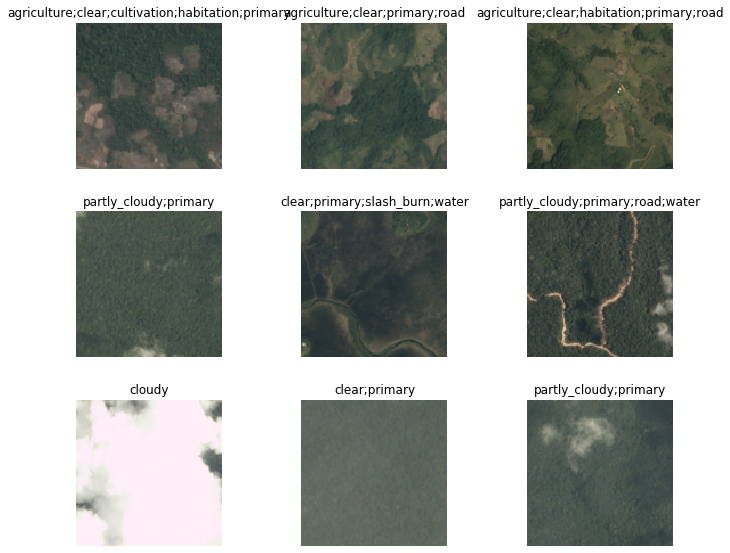

In [0]:
data.show_batch(rows=3, figsize=(10,8), ds_type=DatasetType.Valid)


In [0]:
print(data.classes)
len(data.classes),data.c

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


(17, 17)

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.984794,0.865251,0.849706,00:04
1,0.873878,0.707357,0.894118,00:04
2,0.776873,0.583334,0.868823,00:04
3,0.705001,0.482885,0.882059,00:04


In [0]:
learn.save('stage-1')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

False

IndexError: ignored

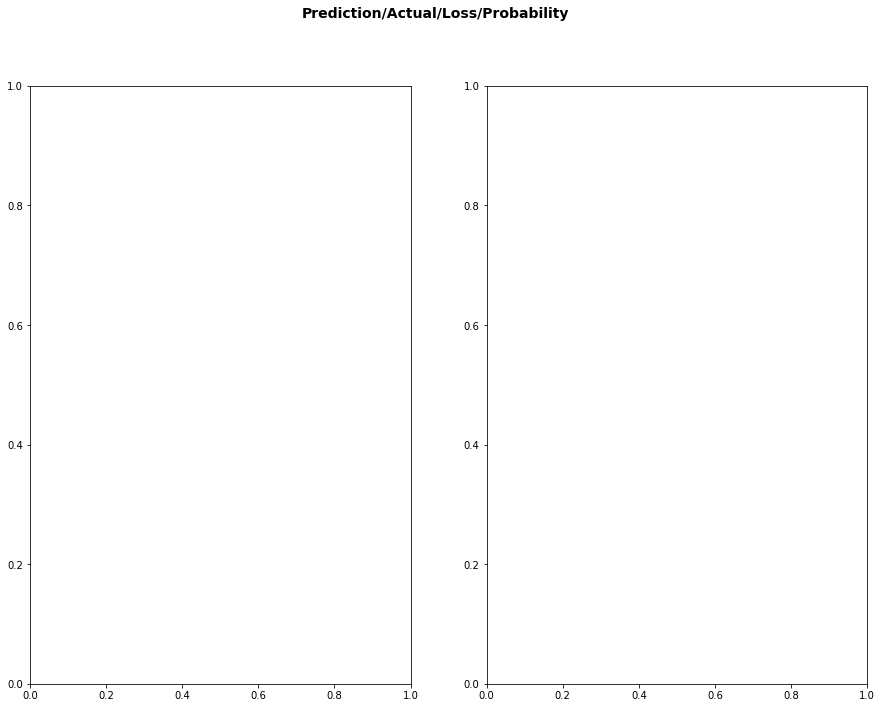

In [0]:
interp.plot_top_losses(2, figsize=(15,11))

In [0]:
doc(interp.plot_top_losses)

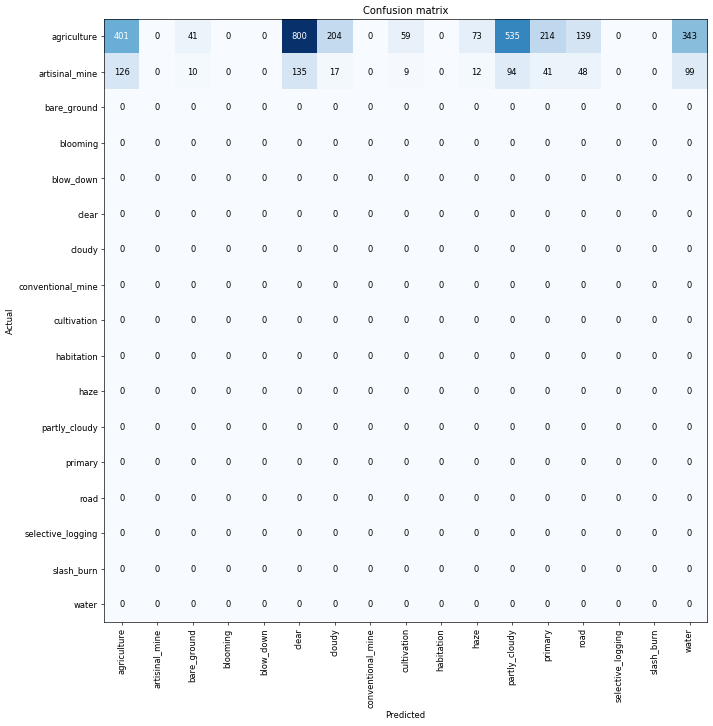

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp.most_confused(min_val=2)

[('agriculture', 'clear', 800),
 ('agriculture', 'partly_cloudy', 535),
 ('agriculture', 'water', 343),
 ('agriculture', 'primary', 214),
 ('agriculture', 'cloudy', 204),
 ('agriculture', 'road', 139),
 ('artisinal_mine', 'clear', 135),
 ('artisinal_mine', 'agriculture', 126),
 ('artisinal_mine', 'water', 99),
 ('artisinal_mine', 'partly_cloudy', 94),
 ('agriculture', 'haze', 73),
 ('agriculture', 'cultivation', 59),
 ('artisinal_mine', 'road', 48),
 ('agriculture', 'bare_ground', 41),
 ('artisinal_mine', 'primary', 41),
 ('artisinal_mine', 'cloudy', 17),
 ('artisinal_mine', 'haze', 12),
 ('artisinal_mine', 'bare_ground', 10),
 ('artisinal_mine', 'cultivation', 9)]

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.529730,0.520116,0.801176,00:04


In [0]:
learn.load('stage-1');

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


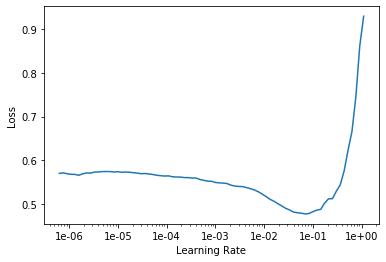

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.562413,0.454536,0.862059,00:04
1,0.563307,0.442667,0.854412,00:04


That's a pretty accurate model!

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


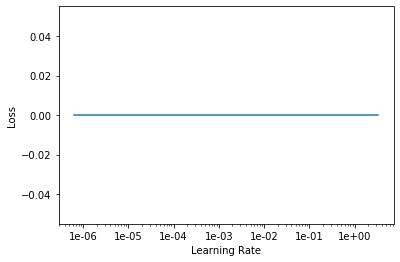

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,02:54
1,0.000000,0.000000,0.000000,02:45
2,0.000000,0.000000,0.000000,02:48
3,0.000000,0.000000,0.000000,02:53
4,0.000000,0.000000,0.000000,02:51
5,0.000000,0.000000,0.000000,02:49
6,0.000000,0.000000,0.000000,02:50
7,0.000000,0.000000,0.000000,02:54


In [0]:
learn.save('stage-1-50')

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

In [0]:
learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.most_confused(min_val=2)